In [1]:
import numpy as np
import pandas as pd
import ROOT as r
import awkward as ak
import os 
import sys
import time
import uproot 
from functools import partial
from makeQuickPlots import quickPlot
from triggerConstants import *
from pandas.api.indexers import BaseIndexer

Warning in <TInterpreter::ReadRootmapFile>: class  edm::Wrapper<std::vector<bool> > found in libDataFormatsWrappedStdDictionaries.so  is already in libOSUT3AnalysisAnaTools.so 
Warning in <TInterpreter::ReadRootmapFile>: class  edm::Wrapper<vector<bool> > found in libDataFormatsWrappedStdDictionaries.so  is already in libOSUT3AnalysisAnaTools.so 


Welcome to JupyROOT 6.24/07


In [2]:
class CustomIndexer(BaseIndexer):
    
    def get_window_bounds(self, num_values, min_periods, center, closed):
        
        start = np.arange(num_values, dtype='int64')
        end = np.arange(num_values, dtype='int64')
        endTimes = self.time + self.duration

        for i in range(num_values):
            #print("Matching event", self.event[i], "pulse", i)
            for j in range(i+1, num_values):
                #if self.debug: print("i", self.event[i], "j", self.event[j], "Start: ", start[i], "End:", end[i], "Diff:", self.time[j] - endTimes[i], "Pass:", (self.time[j] - endTimes[i]) > self.threshold)
                if self.event[i] != self.event[j]: 
                    #print("breaking because events unequal")
                    break
                #print(self.event[i],self.time[j], endTimes[i], (self.time[j] - endTimes[i]), self.threshold)
                if (self.time[j] - endTimes[i]) > self.threshold: break
                else: end[i] = j+1
        #print(start, end)

        return start, end 

In [31]:
class triggerChecker():

    def __init__(self):
        self.defineFunctions()
        #self.pedestalCorrections = np.array(pedestalCorrections) #this line deals with static pedestal correction
        
    def setDynamicPedestals(self, evtNum=-1):
        if evtNum < 0:
            self.pedestals = self.tree.arrays(['event', 'chan', 'dynamicPedestal'], library='ak')
        else:
            self.pedestals = self.tree.arrays(['event', 'chan', 'dynamicPedestal'], library='ak', entry_start=evtNum, entry_stop=evtNum+1)
        self.corrections = [x.dynamicPedestal[x.chan].to_list() for x in self.pedestals]
        self.corrections = [item for sublist in self.corrections for item in sublist]

    #check for nHits pulses in window
    def checkNPulses(self, x, nHits=4):
        if len((x.unique()<64)) >= nHits: return True
        return False

    #check for NLayers hits in window
    def checkNLayers(self, x, nLayers=4):
        #if len(x) < nLayers: return False
        unique = x.unique()
        layers = np.where((unique >= 0) & (unique < 4))
        return layers[0].size >= nLayers

    #return value of column (for debugging)
    def returnValue(self, x):
        return x.values[0]

    #check for separate layers in window
    def checkSeparate(self, x):
        hit = (np.array([np.in1d(combo, x) for combo in separateCombos]).all(1)).any()
        return hit

    #check for adjacent layers in window
    def checkAdjacent(self, x):
        hit = (np.array([np.in1d(combo, x) for combo in adjacentCombos]).all(1)).any()
        return hit

    #check for top panels trigger in window
    def checkTopPanels(self, x, bot=False):
        hit = np.array([np.in1d(panel, x) for panel in topPanels]).any()
        if not bot: return hit    
        extra = np.array([np.in1d(chan, x) for chan in bottomBars]).any()
        return extra*hit

    #check for front+back panels in window
    def checkThroughGoing(self, x):
        hit = np.array([np.in1d(panel, x) for panel in frontBack]).all()
        return hit

    #check for 3 in row trigger in window
    def checkThreeInRow(self, x):
        #passed = np.array([np.count_nonzero([np.in1d(path, x) for path in line]) >= 3 for line in straightPaths]).any()
        for line in straightPaths:
            hits = []
            for i, path in enumerate(line):
                if np.in1d(path,x).any():
                    hits.append(i)
            if len(np.unique(np.array(hits))) >=3: 
                return True
        return False

    #define columns replaced by trigger finding
    def defineTrigCols(self, pedestalCorrection=False):
        if pedestalCorrection: 
            self.myarray = self.myarray.assign(pedestalCorrection = lambda x: self.corrections)
            #self.myarray = self.myarray.assign(pedestalCorrection=lambda x: self.pedestalCorrections[x.chan]) #this line undoes the static pedestal correction from json (not needed?)
            self.myarray['correctedHeight'] = np.where((self.myarray['height'] + self.myarray['pedestalCorrection'] >= 15), True, False)
            self.myarray = self.myarray.loc[self.myarray['correctedHeight'] == True]
        self.myarray['fourLayers'] = np.where((self.myarray['type'] == 0), self.myarray['layer'], -1)
        self.myarray['threeInRow'] = self.myarray['chan']
        self.myarray['separateLayers'] = self.myarray['layer']
        self.myarray['adjacentLayers'] = self.myarray['layer']
        self.myarray['nLayers'] = self.myarray['layer']
        self.myarray['nHits'] = self.myarray['layer']
        self.myarray['topPanels'] = self.myarray['chan']
        self.myarray['topBotPanels'] = self.myarray['chan']
        self.myarray['panelsCleaned'] = np.where((self.myarray['height'] >= panelThreshold), self.myarray['chan'], False)
        self.myarray['frontBack'] = self.myarray['panelsCleaned']

    #function to open the input root file
    def openFile(self, dataIn, evtNum = -1, debug=False, pedestalCorrection=False):
        self.input_file = dataIn
        self.runNum = int(dataIn.split('Run')[-1].split('.')[0])
        self.fileNum = int(dataIn.split('.')[1].split('_')[0])
        self.fin = uproot.open(dataIn)
        self.tree = self.fin['t']
        if debug: self.myarray = self.tree.arrays(uprootInputs, library='pd', entry_stop=10)
        if evtNum < 0:
            self.myarray = self.tree.arrays(uprootInputs, library='pd')
        else: 
            self.myarray = self.tree.arrays(uprootInputs, library='pd', entry_start=evtNum, entry_stop=evtNum+1)
        self.setDynamicPedestals(evtNum)
        self.defineTrigCols(pedestalCorrection)
        self.setTimes()

    #use datetime to create times of hits to be used in rolling window
    def setTimes(self):
        self.myarray['fake_time'] = pd.to_datetime((self.myarray['time']+self.myarray['event']*86400), unit='s')  
        self.myarray = self.myarray.sort_values(by=['entry', 'time'], ascending=True)

    #define specific trigger functions from generic functions
    def defineFunctions(self):
        self.thisNLayers = partial(self.checkNLayers, nLayers=nLayers)
        self.thisNPulses = partial(self.checkNPulses, nHits=nHits)
        self.topBotPanels = partial(self.checkTopPanels, bot=True)
        self.this4Layers = partial(self.checkNLayers, nLayers=4)

    #find the triggers in offline data
    def findTriggersOffline(self, trigWindow = 160, custom=True, checkEvent=-1):
        time = self.myarray['time'].to_numpy()
        duration = self.myarray['duration'].to_numpy()
        event = self.myarray['event'].to_numpy()
        indexer = CustomIndexer(time=self.myarray['time'].to_numpy(), duration=self.myarray['duration'].to_numpy(), event=self.myarray['event'].to_numpy(), threshold=trigWindow, debug=True)
        #use a rolling window to find the triggers that should pass
        if not custom: 
            self.myarray[offlineTrigNames] = self.myarray.rolling(window='{}s'.format(trigWindow), on="fake_time", axis=0).agg({"fourLayers": self.this4Layers, "threeInRow": self.checkThreeInRow, "separateLayers": self.checkSeparate, "adjacentLayers": self.checkAdjacent, 'nLayers': self.thisNLayers, 'nHits': self.thisNPulses, 'topPanels': self.checkTopPanels, 'topBotPanels': self.topBotPanels, 'frontBack': self.checkThroughGoing})
        if custom: 
            self.myarray[offlineTrigNames] = self.myarray.rolling(indexer, axis=0).agg({"fourLayers": self.this4Layers, "threeInRow": self.checkThreeInRow, "separateLayers": self.checkSeparate, "adjacentLayers": self.checkAdjacent, 'nLayers': self.thisNLayers, 'nHits': self.thisNPulses, 'topPanels': self.checkTopPanels, 'topBotPanels': self.topBotPanels, 'frontBack': self.checkThroughGoing})

                
    #convert all triggers to binary
    def convertTriggers(self, df):
        trig = format(int(df), '#016b').split("b")[-1]
        trig = trig[::-1]
        return trig

    #get value of specific trigger bit
    def getTriggerBit(self, df, bit):
        return int(df[bit])

    #get triggers passed online
    def getOnlineTriggers(self):
        self.myarray['triggerString'] = self.myarray.apply(lambda row: self.convertTriggers(row.tTrigger), axis=1)
        for i in range(13):
            self.myarray['trig{}'.format(i)] = self.myarray.apply(lambda row: self.getTriggerBit(row.triggerString, i), axis=1)

    #open the output file for plots
    def openOutputFile(self):
        outputFilename = os.getcwd() + '/triggerRates_Run{0}.{1}.root'.format(self.runNum, self.fileNum)
        self.file_out = r.TFile.Open(outputFilename, 'recreate')

    #create plots of the online/offline triggers passed
    def plotTriggers(self):
        self.openOutputFile()
        h_triggers = r.TH1F("h_triggers", "Recorded Triggers", 13, 0, 13)
        h_offline = r.TH1F("h_offline", "Offline Triggers Found", 13, 0, 13)
        c1 = r.TCanvas("c1", "c1", 800, 800)
        
        checkTrig = 0
        checkOnline = []
        checkOffline = []
        onlyOnline = []
        onlyOffline = []

        onlineTrigs = []
        for i in range(13):                
            events = np.unique(self.myarray['event'].loc[self.myarray['trig{}'.format(i)] == True].to_numpy())
            if i == 0: print("onlineTrigs", events)
            onlineTrigs.append(len(events))
            h_triggers.Fill(i, len(events))
            #if i == checkTrig:
            checkOnline.append(events)


        offlineTrigs = np.zeros(13)
        for itrig, trig in enumerate(offlineTrigArray):
            events = np.unique(self.myarray[['event']].loc[self.myarray[trig[0]] == True].to_numpy())
            if itrig == 0: print("offlineTrigs", events)
            offlineTrigs[trig[1]] = len(events)
            h_offline.Fill(trig[1], len(events))
            #if itrig == checkTrig:
            checkOffline.append(events)
                        
            onlyOnline.append([x for x in checkOnline[itrig] if x not in checkOffline[itrig]])
            onlyOffline.append([x for x in checkOffline[itrig] if x not in checkOnline[itrig]])
            print("Trigger {}".format(trig))
            print("\tOnline only", ''.join(str(onlyOnline[itrig])))
            print("\tOffline only", ''.join(str(onlyOffline[itrig])))

        print("-----------------------Trigger Counts-------------------------")
        print("{0:<30} {1:>8} {2:>15}".format("Trigger", "Online Triggers", "Offline Triggers"))
        print("{0:<30} {1:>8} {2:>15}".format('Trigger 1: FourLayers:', onlineTrigs[0], offlineTrigs[0]))
        print("{0:<30} {1:>8} {2:>15}".format('Trigger 2: 3InRow', onlineTrigs[1], offlineTrigs[1]))
        print("{0:<30} {1:>8} {2:>15}".format('Trigger 3: separateLayers ', onlineTrigs[2], offlineTrigs[2]))
        print("{0:<30} {1:>8} {2:>15}".format('Trigger 4: adjacentLayers', onlineTrigs[3], offlineTrigs[3]))
        print("{0:<30} {1:>8} {2:>15}".format('Trigger 5: NLayers', onlineTrigs[4], offlineTrigs[4]))
        print("{0:<30} {1:>8} {2:>15}".format('Trigger 6: External', onlineTrigs[5], offlineTrigs[5]))
        print("{0:<30} {1:>8} {2:>15}".format('Trigger 7: NHits', onlineTrigs[6], offlineTrigs[6]))
        print("{0:<30} {1:>8} {2:>15}".format('Trigger 8: Internal', onlineTrigs[7], offlineTrigs[7]))
        print("{0:<30} {1:>8} {2:>15}".format('Trigger 9: TopPanels', onlineTrigs[8], offlineTrigs[8]))
        print("{0:<30} {1:>8} {2:>15}".format('Trigger 10: TopPanelBotBar', onlineTrigs[9], offlineTrigs[9]))
        print("{0:<30} {1:>8} {2:>15}".format('Trigger 11: FrontBackPanel', onlineTrigs[10], offlineTrigs[10]))
        print("{0:<30} {1:>8} {2:>15}".format('Trigger 12: SParticle', onlineTrigs[11], offlineTrigs[11]))
        print("{0:<30} {1:>8} {2:>15}".format('Trigger 13: ZeroBias', onlineTrigs[12], offlineTrigs[12]))
        print("---------------------------------------------------------------")

        c1.cd()
        h_offline.SetLineColor(2)
        h_offline.Draw("hist text")
        h_triggers.Draw("hist text same")
        l1 = r.TLegend(0.6, 0.5, 0.8, 0.6)
        l1.AddEntry(h_offline)
        l1.AddEntry(h_triggers)
        l1.Draw("same")
        self.file_out.cd()
        c1.Write()
        h_offline.Write()
        h_triggers.Write()

    def printEvent(self, evtNum):
        print(self.myarray[['event', 'time', 'duration', 'fourLayers', 'trig0', 'layer', 'chan', 'tTrigger']].loc[self.myarray['event'] == evtNum])
        print(self.myarray[['fourLayers', 'threeInRow', 'separateLayers', 'adjacentLayers', 'nLayers', 'nHits', 'topPanels', 'topBotPanels', 'frontBack']].loc[self.myarray['event'] == evtNum])
        print(self.myarray[['trig0', 'trig1', 'trig2', 'trig3', 'trig4', 'trig5', 'trig6', 'trig7']].loc[self.myarray['event'] == evtNum])

In [32]:
#filename = '~/scratch0/milliQan/MilliQan_Run1114.1_test.root'
filename = '/home/milliqan/scratch0/processTrees/milliqanOffline/Run3Detector/MilliQan_Run1116.1_matched.root'
#filename = '~/dump/MilliQan_Run1116.1_default_v32.root'

mychecker = triggerChecker()
mychecker.openFile(filename, evtNum=-1, debug=False, pedestalCorrection=True)
mychecker.findTriggersOffline(custom=True)
mychecker.getOnlineTriggers()
mychecker.plotTriggers()

onlineTrigs [ 18  20  24  41  55  78  79  83 102 104 119 120 129 147 153 166 190 234
 262 275 317 322 339 347 348 355 366 374 400 405 416 429 439 467 471 509
 510 547 561 613 618 626 642 665 679 681 682 706 713 715 723 741 748 779
 782 815 829 870 883 911 930 941 953 979 984 988 992]
offlineTrigs [ 18  20  24  55  78  83 104 147 153 166 190 234 262 275 317 322 339 347
 355 366 374 400 405 416 429 432 439 467 471 509 510 547 561 613 618 626
 665 679 682 702 706 713 715 723 741 748 779 815 829 870 883 911 930 946
 953 966 979 984 988 992]
Trigger ['fourLayers', 0]
	Online only [41, 79, 102, 119, 120, 129, 348, 642, 681, 782, 941]
	Offline only [432, 702, 946, 966]
Trigger ['threeInRow', 1]
	Online only [44, 79, 89, 91, 121, 127, 135, 148, 168, 280, 287, 291, 309, 315, 399, 413, 422, 499, 507, 529, 557, 567, 627, 646, 676, 703, 727, 761, 772, 784, 840, 847, 857, 861, 873, 874, 915, 958, 987, 995]
	Offline only [119, 429]
Trigger ['separateLayers', 2]
	Online only [599, 768]
	Offline only 

In [5]:
mychecker.printEvent(5)


Empty DataFrame
Columns: [event, time, duration, fourLayers, trig0, layer, chan, tTrigger]
Index: []
Empty DataFrame
Columns: [fourLayers, threeInRow, separateLayers, adjacentLayers, nLayers, nHits, topPanels, topBotPanels, frontBack]
Index: []
Empty DataFrame
Columns: [trig0, trig1, trig2, trig3, trig4, trig5, trig6, trig7]
Index: []


In [29]:
mychecker.myarray[['event', 'time', 'duration', 'chan', 'pedestalCorrection', 'height', 'layer', 'fourLayers', 'threeInRow', 'trig0', 'trig1']].loc[mychecker.myarray['event']==429]



event    time   duration  chan  pedestalCorrection  \
entry subentry                                                       
429   16          429   220.0  444.98999    41                0.75   
      20          429   250.0  242.48999    71               -2.00   
      13          429   467.5  252.48999    37               -0.50   
      12          429   477.5  367.48999    34                0.00   
      21          429   485.0  762.48999    73                4.50   
      14          429   912.5  207.48999    37               -0.50   
      7           429  1180.0  354.98999    17                0.25   
      10          429  1185.0  242.48999    19               -1.00   
      17          429  1192.5  172.48999    41                0.75   
      0           429  1247.5  257.48999     4               -0.50   
      4           429  1252.5  224.98999     5               -0.25   
      11          429  1255.0  242.48999    28                0.00   
      19          429  1262.5  262.48999    68               -0.25   
      18          429  1300.0   84.98999    52               -0.25   
      22          429  1350.0  104.98999    73                4.50   
      23          429  1465.0  119.98999    73                4.50   
      8           429  1707.5  142.48999    17                0.25   
      1           429  1732.5  117.48999     4               -0.50   
      24          429  1737.5  207.48999    73                4.50   
      15          429  1767.5  119.98999    37               -0.50   
      2           429  1850.0  107.48999     4               -0.50   
      9           429  1927.5  102.48999    17                0.25   
      3           429  2107.5   92.48999     4               -0.50   
      25          429  2327.5  114.98999    73                4.50   

                     height  layer  fourLayers  threeInRow  trig0  trig1  
entry subentry                                                            
429   16        1249.523682      2         0.0         0.0      1      0  
      20         271.238373     -1         0.0         0.0      1      0  
      13        1086.836670      2         0.0         0.0      1      0  
      12        1249.700073      2         0.0         0.0      1      0  
      21        1247.543091      2         1.0         1.0      1      0  
      14          69.350517      2         0.0         0.0      1      0  
      7         1249.411499      1         1.0         0.0      1      0  
      10         637.825684      1         1.0         0.0      1      0  
      17         142.828613      2         1.0         0.0      1      0  
      0         1077.138550      0         0.0         0.0      1      0  
      4          546.622803      0         0.0         0.0      1      0  
      11         395.813599      1         0.0         0.0      1      0  
      19         185.100037      0         0.0         0.0      1      0  
      18          21.477514      3         0.0         0.0      1      0  
      22          48.779503      2         0.0         0.0      1      0  
      23          98.227066      2         0.0         0.0      1      0  
      8           63.720787      1         0.0         0.0      1      0  
      1           82.690147      0         0.0         0.0      1      0  
      24         895.495056      2         0.0         0.0      1      0  
      15          80.331963      2         0.0         0.0      1      0  
      2           59.588821      0         0.0         0.0      1      0  
      9           54.228401      1         0.0         0.0      1      0  
      3           46.549786      0         0.0         0.0      1      0  
      25         113.628304      2         0.0         0.0      1      0

In [28]:
from makeQuickPlots import quickPlot

myplotter = quickPlot()
myplotter.runNum = 1116
myplotter.fileNum = 1
myplotter.events = [468]

myplotter.parseInputFile()
myplotter.callSingularity()
myplotter.copyDisplays()

None None /home/mcarrigan/.local/share/jupyter/runtime/kernel-6f53a00b-1bdb-4218-ac3a-377a4563bdb6.json
Input file: /store/user/milliqan/run3/1100/0001/MilliQan_Run1116.1_default.root


TypeError: sequence item 0: expected str instance, int found

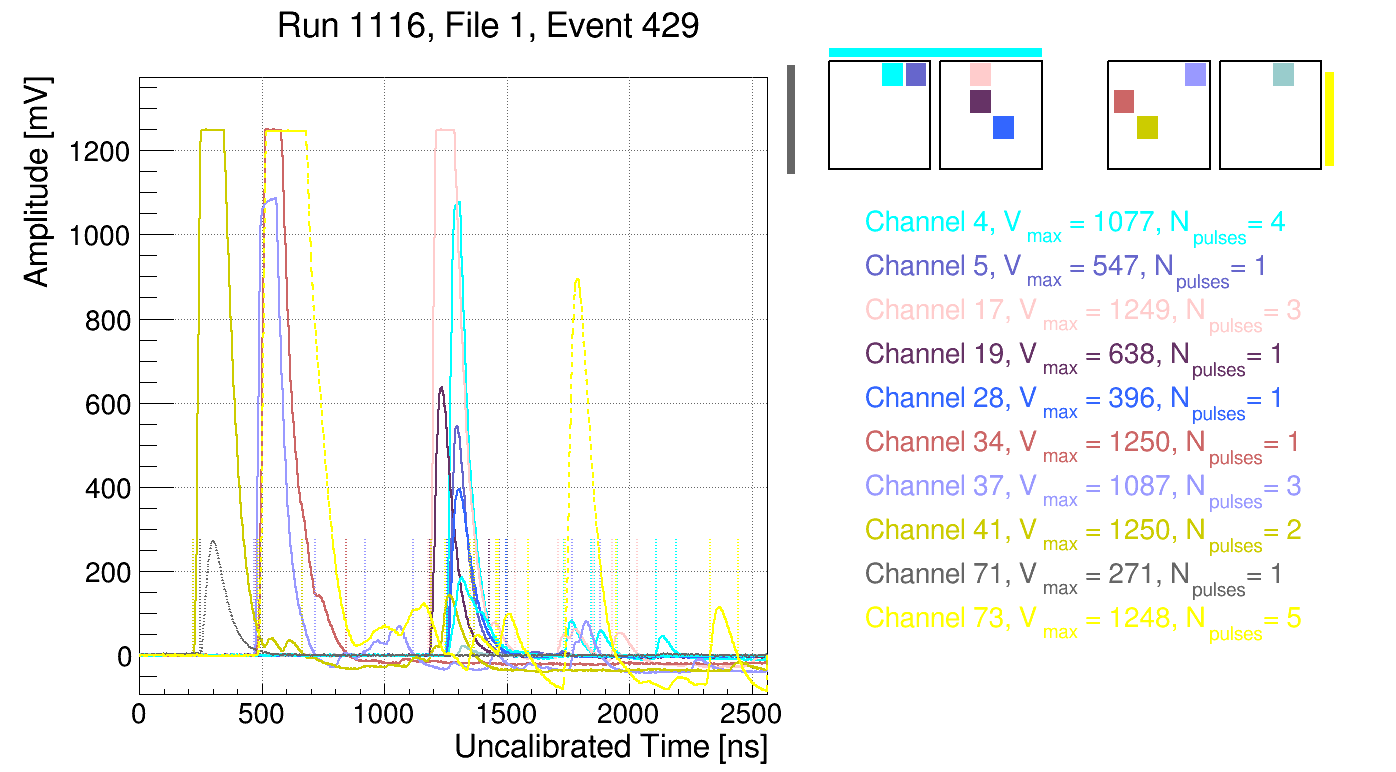

In [27]:
from IPython.display import Image

Image('Run1116/Run1116_File1_Event429_Version_v32.png')